### Import necessary libraries

In [1]:
import pandas as pd
import nltk
import re
import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#nltk.download('wordnet')

### Read data into dataframe

In [3]:
db=pd.read_csv('data/enron_spam_ham_email_processed_v2.csv')
db.head(10)

,Subject,Message,label
0,christmas tree farm picture,message text,0
1,vastar resource inc .,gary production high island large block commen...,0
2,calpine daily gas nomination,calpine daily gas nomination .,0
3,issue,fyi see note already . stella forward stella l...,0
4,meter nov allocation,forward lauri allen hou ect pm kimberly vaughn...,0
5,mcmullen gas,jackie since inlet river plant shut last day f...,0
6,meter jan,george need follow jan zero receipt package id...,0
7,dun number change,fyi forward gary l payne hou ect pm antoine v ...,0
8,king ranch,two field gas difficulty unify system . cage r...,0
9,entex transistion,thanks much memo . would like reiterate suppor...,0


### Apply Tfidf Vectorization on subject and message data

In [4]:
#Apply tfidf on subject data
sub_vectorizer=TfidfVectorizer()
subject=sub_vectorizer.fit_transform(db['Subject'])
nof_elements_sub=int(str(subject.__str__).split(' ')[str(subject.__str__).split(' ').index('stored')-1])
print(f'Sparse matrix of size {subject.shape} has {nof_elements_sub} elements, {nof_elements_sub/(subject.shape[0]*subject.shape[1])*100:.4f}% dense')

#Apply tfidf on message data
msg_vectorizer=TfidfVectorizer()
message=msg_vectorizer.fit_transform(db['Message'])
nof_elements_msg=int(str(message.__str__).split(' ')[str(message.__str__).split(' ').index('stored')-1])
print(f'Sparse matrix of size {message.shape} has {nof_elements_msg} elements, {nof_elements_msg/(message.shape[0]*message.shape[1])*100:.4f}% dense')

Sparse matrix of size (33665, 13923) has 121410 elements, 0.0259% dense
Sparse matrix of size (33665, 128539) has 2744163 elements, 0.0634% dense


### Split the dataset for both subject and message

In [5]:
#Subject train-test split
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(subject, db['label'], test_size=0.33, random_state=42)

#Message train-test split
X_msg_train, X_msg_test, y_msg_train, y_msg_test = train_test_split(message, db['label'], test_size=0.33, random_state=42)

### Initialize classifiers

In [6]:
#Define random state for repeatable results
rnd_state=42

#Subject model parameters
model_sub_params={
    #LogisticRegression Classifier
    'lr_sub':{
        'model': LogisticRegression(solver='saga',max_iter=1000,penalty='elasticnet',l1_ratio=0.3,random_state=rnd_state,n_jobs=-1),
        'params':{'C':[0.1,1,10]}
    },
    #SupportVectorMachine Classifier
    'svm_sub':{
        'model':SVC(gamma='scale',class_weight='balanced',random_state=rnd_state),
        'params':{'C':[0.01,1,100],'kernel':['linear','rbf','sigmoid']}
    },
    #RandomForest Classifier
    'rf_sub':{
        'model':RandomForestClassifier(random_state=rnd_state,n_jobs=-1),
        'params':{'n_estimators':[10,30],'max_depth':[5,10,None],'min_samples_split':[2,5],'max_features':['log2',None],'bootstrap':[True,False]}
    }
}

#Message model parameters
model_msg_params={
    #LogisticRegression Classifier
    'lr_msg':{
        'model': LogisticRegression(solver='saga',max_iter=1000,penalty='elasticnet',l1_ratio=0.3,random_state=rnd_state,n_jobs=-1),
        'params':{'C':[0.1,1,10]}
    },
    #SupportVectorMachine Classifier
    'svm_msg':{
        'model':SVC(gamma='scale',class_weight='balanced',random_state=rnd_state),
        'params':{'C':[0.01,1,100],'kernel':['linear','rbf','sigmoid']}
    },
    #RandomForest Classifier
    'rf_msg':{
        'model':RandomForestClassifier(random_state=rnd_state,n_jobs=-1),
        'params':{'n_estimators':[10,30],'max_depth':[5,10,None],'min_samples_split':[2,5],'max_features':['log2',None],'bootstrap':[True,False]}
    }
}

## Subject training, testing, and scoring
### Run models through RandomizedSearchCV and store best parameters

In [7]:
#Training & Testing - Subject

t=time.time()

scores_sub=[]
models_sub=[]
for mdl_name,mdl in model_sub_params.items():
    print(f'Model {mdl_name}... Elapsed: {(time.time()-t)//60:.0f} m {(time.time()-t)%60:.0f} s')
    scores_sub_model=[]
    rscv=RandomizedSearchCV(mdl['model'],mdl['params'],n_iter=5,cv=3,scoring='accuracy',n_jobs=-1)
    rscv.fit(X_sub_train,y_sub_train)
    models_sub.append(rscv.best_estimator_)
    for i in zip(rscv.cv_results_['mean_test_score'],rscv.cv_results_['params']):
        scores_sub_model.append(i)
    scores_sub.append({'model': mdl_name,
                  'best_score': rscv.best_score_,
                  'best_params':rscv.best_params_,
                  'every_param_comb':scores_sub_model})

print(f'Total Elapsed: {(time.time()-t)//60:.0f} m {(time.time()-t)%60:.0f} s')

Model lr_sub... Elapsed: 0 m 0 s


C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model svm_sub... Elapsed: 1 m 28 s
Model rf_sub... Elapsed: 3 m 34 s
Total Elapsed: 4 m 1 s


### View best scores and parameters

In [16]:
#Viewing Scores
scr_sub=pd.DataFrame(scores_sub)
best_alg=scr_sub.sort_values(by='best_score',ascending=False)
print(f"{'Alg.':<9} {'BestScore':<9} {'Corresponding Parameters':^100}")
for i in range(best_alg.shape[0]):
    print(f"{best_alg.iloc[i,0]:<9} {best_alg.iloc[i,1]*100:<9.4f} {str(best_alg.iloc[i,2]):<100}")

print(f"\nBest algorithm is {best_alg.iloc[0,0]}, accuracy: {best_alg.iloc[0,1]*100:0.4f}, parameters: {best_alg.iloc[0,2]}")

#print('Algorithm wise models and corresponding hyperparameter')
#for i in range(scr_sub.shape[0]):
#    print(f'\nModel: {scr_sub.iloc[i,:2][0]}, Best_Score: {scr_sub.iloc[i,:2][1]:.4f}')
#    print(pd.DataFrame(scr_sub.iloc[i,3],columns=['Score','HyperParameter']).sort_values(by=['Score'],ascending=False))

Alg.      BestScore                                       Corresponding Parameters                                      
svm_sub   92.3565   {'kernel': 'rbf', 'C': 1}                                                                           
lr_sub    91.5362   {'C': 10}                                                                                           
rf_sub    91.2614   {'n_estimators': 10, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}

Best algorithm is svm_sub, accuracy: 92.3565, parameters: {'kernel': 'rbf', 'C': 1}


### Select best model and view scores along with confusion matrix

Accuracy_subject: 93.7534%

 Label      Precision     Recall    F1_Score     Support
NonSpam      0.9521       0.9184      0.9350      5432
 Spam        0.9245       0.9558      0.9399      5678

Confusion Matrix: 



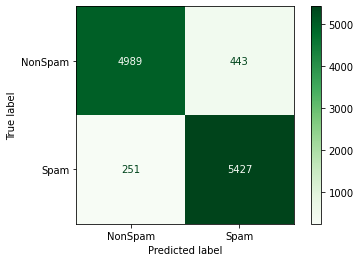

In [17]:
#Selecting best model
best_sub_model=models_sub[1]

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
#Metrics - Accuracy
print(f'Accuracy_subject: {best_sub_model.score(X_sub_test,y_sub_test)*100:.4f}%')

#Metrics - Precision, Recall and F1_Score
y_sub_pred=best_sub_model.predict(X_sub_test)
(p,r,f1,s)=precision_recall_fscore_support(y_sub_test, y_sub_pred, average=None, labels=[0,1])
labels=['NonSpam','Spam']
print(f"\n{'Label':^7} {'Precision':^17} {'Recall':^5} {'F1_Score':^15} {'Support'}")
for i in range(len(labels)):
    print(f"{labels[i]:^7}{p[i]:^19.4f}{r[i]:^7.4f}{f1[i]:^17.4f}{s[i]}")

#Metrics - Confusion Matrix
print(f'\nConfusion Matrix: \n')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_sub_test,y_sub_pred),display_labels=labels)
disp.plot(cmap='Greens')
plt.show()

## Message training, testing, and scoring
### Run models through RandomizedSearchCV and store best parameters

In [12]:
#Training & Testing - Message
t=time.time()

scores_msg=[]
models_msg=[]
for mdl_name,mdl in model_msg_params.items():
    print(f'Model {mdl_name}... Elapsed: {(time.time()-t)//60:.0f} m {(time.time()-t)%60:.0f} s')
    scores_msg_model=[]
    rscv=RandomizedSearchCV(mdl['model'],mdl['params'],n_iter=5,cv=3,scoring='accuracy',n_jobs=-1)
    rscv.fit(X_msg_train,y_msg_train)
    models_msg.append(rscv.best_estimator_)
    for i in zip(rscv.cv_results_['mean_test_score'],rscv.cv_results_['params']):
        scores_msg_model.append(i)
    scores_msg.append({'model': mdl_name,
                  'best_score': rscv.best_score_,
                  'best_params':rscv.best_params_,
                  'every_param_comb':scores_msg_model})

print(f'Total Elapsed: {(time.time()-t)//60:.0f} m {(time.time()-t)%60:.0f} s')

Model lr_msg... Elapsed: 0 m 0 s


C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model svm_msg... Elapsed: 1 m 54 s
Model rf_msg... Elapsed: 9 m 56 s
Total Elapsed: 10 m 16 s


### View best scores and parameters

In [13]:
#Viewing Scores
scr_msg=pd.DataFrame(scores_msg)
best_alg=scr_msg.sort_values(by='best_score',ascending=False)
print(f"{'Alg.':<9} {'BestScore':<9} {'Corresponding Parameters':^100}")
for i in range(best_alg.shape[0]):
    print(f"{best_alg.iloc[i,0]:<9} {best_alg.iloc[i,1]*100:<9.4f} {str(best_alg.iloc[i,2]):<100}")

print(f"\nBest algorithm is {best_alg.iloc[0,0]}, accuracy: {best_alg.iloc[0,1]*100:0.4f}, parameters: {best_alg.iloc[0,2]}")

#print('Algorithm wise models and corresponding hyperparameter')
#for i in range(scr_sub.shape[0]):
#    print(f'\nModel: {scr_sub.iloc[i,:2][0]}, Best_Score: {scr_sub.iloc[i,:2][1]:.4f}')
#    print(pd.DataFrame(scr_sub.iloc[i,3],columns=['Score','HyperParameter']).sort_values(by=['Score'],ascending=False))

Alg.      BestScore                                       Corresponding Parameters                                      
svm_msg   98.3773   {'kernel': 'linear', 'C': 1}                                                                        
lr_msg    98.1024   {'C': 10}                                                                                           
rf_msg    96.2758   {'n_estimators': 10, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}

Best algorithm is svm_msg, accuracy: 98.3773, parameters: {'kernel': 'linear', 'C': 1}


### Select best model and view scores along with confusion matrix

Accuracy_message: 98.5059%

 Label      Precision     Recall    F1_Score     Support
NonSpam      0.9946       0.9748      0.9846      5432
 Spam        0.9763       0.9949      0.9855      5678

Confusion Matrix: 



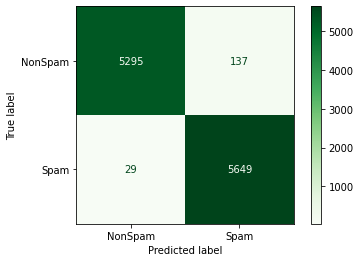

In [14]:
#Selecting best model
best_msg_model=models_msg[1]

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
#Metrics - Accuracy
print(f'Accuracy_message: {best_msg_model.score(X_msg_test,y_msg_test)*100:.4f}%')

#Metrics - Precision, Recall and F1_Score
y_msg_pred=best_msg_model.predict(X_msg_test)
(p,r,f1,s)=precision_recall_fscore_support(y_msg_test, y_msg_pred, average=None, labels=[0,1])
labels=['NonSpam','Spam']
print(f"\n{'Label':^7} {'Precision':^17} {'Recall':^5} {'F1_Score':^15} {'Support'}")
for i in range(len(labels)):
    print(f"{labels[i]:^7}{p[i]:^19.4f}{r[i]:^7.4f}{f1[i]:^17.4f}{s[i]}")
    
#Metrics - Confusion Matrix
print(f'\nConfusion Matrix: \n')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_msg_test,y_msg_pred),display_labels=labels)
disp.plot(cmap='Greens')
plt.show()